[HOG] Estrazione in corso...
[HOG] Feature vector (dim 8100): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

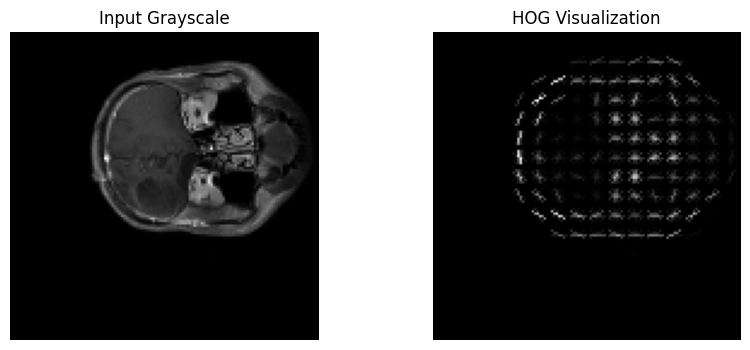

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# === Funzione: Estrazione HOG ===
def extract_hog_features(img_path):
    print("[HOG] Estrazione in corso...")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione fissa

    features, hog_image = hog(resized,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    print(f"[HOG] Feature vector (dim {features.shape[0]}): {features[:900]}")

    # Visualizzazione
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(resized, cmap='gray')
    plt.title("Input Grayscale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis("off")
    plt.show()

    return features

# === Percorso immagine ===
img_path = "Part1/brain_glioma/brain_glioma_0001.jpg"
features = extract_hog_features(img_path)

Seconda implementazione

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms import functional as F
import numpy as np
from matplotlib import pyplot as plt

def visualize_image(image_path):
    """
    Loads and displays an image.

    Args:
        image_path (str): Path to the image file.
    """
    image = read_image(image_path)  # Load the image using torchvision
    plt.imshow(F.to_pil_image(image))
    plt.title("Image")
    plt.show()

def calculate_hog_features(image_path):
    """
    Calculates Histogram of Oriented Gradients (HOG) features for a given image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: 900-dimensional HOG feature descriptor.
    """

    # 1. Load and Preprocess Image
    image = read_image(image_path)
    pil_image = F.to_pil_image(image)  # Convert tensor to PIL Image
    gray_image = F.to_grayscale(pil_image)  # Convert to grayscale
    resized_image = F.resize(gray_image, [300, 10])  # Resize to 300x10
    resized_image = F.to_tensor(resized_image) # Convert back to tensor

    # 2. Calculate Gradients
    #   Using [-1, 0, 1] and [-1, 0, 1].T masks for dI/dx and dI/dy
    dx_filter = torch.tensor([[-1.0, 0.0, 1.0]])
    dy_filter = torch.transpose(dx_filter, 0, 1)

    # Add a channel dimension to resized_image for convolution
    resized_image = resized_image.unsqueeze(0).float()
    dx = torch.conv2d(resized_image, dx_filter.float().unsqueeze(0).unsqueeze(0), padding='same')
    dy = torch.conv2d(resized_image, dy_filter.float().unsqueeze(0).unsqueeze(0), padding='same')

    # Calculate magnitude and orientation
    magnitude = torch.sqrt(dx**2 + dy**2)
    orientation = torch.atan2(dy, dx) * (180 / np.pi)  # Convert radians to degrees

    # 3. Compute Histograms
    cell_size = (30, 1)  # Cell size for the 10x10 grid (300/10, 10/1)
    num_bins = 9  # 9 bins for the histogram (40 degrees per bin)
    histograms = []

    for i in range(0, resized_image.shape[2], cell_size[0]):  # Iterate over rows (height)
        for j in range(0, resized_image.shape[3], cell_size[1]):  # Iterate over columns (width)
            cell_magnitude = magnitude[:, :, i:i + cell_size[0], j:j + cell_size[1]]
            cell_orientation = orientation[:, :, i:i + cell_size[0], j:j + cell_size[1]]

            histogram = torch.zeros(num_bins)
            for bin in range(num_bins):
                # Calculate bin edges
                lower_bound = -90 + bin * 40
                upper_bound = -90 + (bin + 1) * 40

                # Count pixels within the bin
                in_range = (cell_orientation >= lower_bound) & (cell_orientation < upper_bound)
                histogram[bin] = cell_magnitude[in_range].sum()

            histograms.append(histogram)

    # 4.  Concatenate Histograms
    hog_features = torch.cat(histograms).numpy()

    return hog_features

def print_hog_features(hog_features):
    """
    Prints the HOG feature descriptor in a human-readable format.

    Args:
        hog_features (numpy.ndarray): The 900-dimensional HOG feature vector.
    """

    print("HOG Feature Descriptor:")
    print(hog_features)
    print(f"Shape: {hog_features.shape}")  # Ensure it's 900

if __name__ == '__main__':
    image_file = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Replace with the actual path to your image
    visualize_image(image_file)
    hog_features = calculate_hog_features(image_file)
    print_hog_features(hog_features)

Task 2 : 

In [10]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
import os

# === Funzione: Estrazione HOG ===
def extract_hog_features_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione standard

    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Elaborazione immagini in più sottocartelle ===
def process_multiple_folders_for_hog(base_folder, subfolders):
    image_features = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                print(f"  - Immagine: {filename}")
                features = extract_hog_features_from_image(img_path)
                if features is not None:
                    image_features.append({
                        "filename": filename,
                        "label": label,
                        "features": features
                    })

    return image_features

# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
image_features = process_multiple_folders_for_hog(base_folder, subfolders)

# === Salvataggio CSV ===
df = pd.DataFrame([{
    "filename": entry["filename"],
    **{f"f{i}": val for i, val in enumerate(entry["features"])}
} for entry in image_features])

df.to_csv("hog_features_all.csv", index=False)
print("[SALVATO] Dati HOG salvati in hog_features_all.csv")
print(f"[FINE] Elaborate {len(image_features)} immagini da {len(subfolders)} classi.")


[INFO] Elaboro cartella: brain_glioma
  - Immagine: brain_glioma_0001.jpg
  - Immagine: brain_glioma_0002.jpg
  - Immagine: brain_glioma_0003.jpg
  - Immagine: brain_glioma_0004.jpg
  - Immagine: brain_glioma_0005.jpg
  - Immagine: brain_glioma_0006.jpg
  - Immagine: brain_glioma_0007.jpg
  - Immagine: brain_glioma_0008.jpg
  - Immagine: brain_glioma_0009.jpg
  - Immagine: brain_glioma_0010.jpg
  - Immagine: brain_glioma_0011.jpg
  - Immagine: brain_glioma_0012.jpg
  - Immagine: brain_glioma_0013.jpg
  - Immagine: brain_glioma_0014.jpg
  - Immagine: brain_glioma_0015.jpg
  - Immagine: brain_glioma_0016.jpg
  - Immagine: brain_glioma_0017.jpg
  - Immagine: brain_glioma_0018.jpg
  - Immagine: brain_glioma_0019.jpg
  - Immagine: brain_glioma_0020.jpg
  - Immagine: brain_glioma_0021.jpg
  - Immagine: brain_glioma_0022.jpg
  - Immagine: brain_glioma_0023.jpg
  - Immagine: brain_glioma_0024.jpg
  - Immagine: brain_glioma_0025.jpg
  - Immagine: brain_glioma_0026.jpg
  - Immagine: brain_glioma